In [1]:
# Notebook Summary:

# V.History: 
# Date Last Modified: 14 May 2025

# This notebook creates 
    # 1. SMILES text from the determinand definition
    # 2. morgan fingerprints (standard form of describing a chemical name to a computer understandable format), 
    #    from a SMILE text.
    # 3. Applies PCA and t-SNE algorithms to reduce the features. Morgan fingerprints are usually multi-dimensional array. 
    #    Hence feature reduction technique was employed.
    # 4. Identifies the K value using the Elbow method or Silhouette score for the KMeans++ algorithm.
    # 5. storing the results into a common GCP storage locations.

#Following website provides SMILES text for a given chemical Element/Component: 
#   https://pubchem.ncbi.nlm.nih.gov//edit3/index.html

# Additional websites provide information about chemical-related machine learning processing methods.#1. https://matt-swain.com/
#2. https://www.mole.phy.cam.ac.uk/software/software.php
#         Group-Developed Software Primary Software ChemDataExtractor
#         A toolkit for automated extraction of chemical information from the scientific literature.
#         Publication: M.C. Swain, J.M. Cole, J. Chem. Inf. Model, DOI: 10.1021/acs.jcim.6b00207>
#3. https://www.phy.cam.ac.uk/
#4. https://www.cam.ac.uk/

# Citation for ChemDataExtractor
'''
    Swain, M. C., & Cole, J. M. "ChemDataExtractor: A Toolkit for Automated Extraction of Chemical Information 
    from the Scientific Literature", J. Chem. Inf. Model. 2016, 56 (10), pp 1894–1904 10.1021/acs.jcim.6b00207
'''
#Pre-Requisite : 
    #Kernel Python 3 (ipykernel) is required to run this notebook 
    #Required python version - Python 3.7.12 and its compatible Numpy , ScikitLearn libraries
    
#Old Name: 10_NB_Final_Chem2.ipynb

'\n    Swain, M. C., & Cole, J. M. "ChemDataExtractor: A Toolkit for Automated Extraction of Chemical Information \n    from the Scientific Literature", J. Chem. Inf. Model. 2016, 56 (10), pp 1894–1904 10.1021/acs.jcim.6b00207\n'

In [2]:
#Check python version compatibility 3.10 or above is required
!python -V
python_version=!(python --version 2>&1)
print (python_version)

#Python Version should be :
#Python 3.7.12
#['Python 3.7.12']

Python 3.7.12
['Python 3.7.12']


In [3]:
#%run "..//99_Common_Utils/99_NB_CommonUtils.ipynb" #Since it is using python 3.7.12, the common utility can't be used. 
# CommonUtil expects python 3.10 and above

In [4]:
#!source /opt/conda/bin/activate ~/CodePP/chem2

In [5]:
'''
#This step creates a kernel with Python 3.7.12. It's a one-time action, so it is commented out after creation. 
VENV=chemex
conda create -y -q -p $HOME/CodePP/$VENV python=3.7.12 ipykernel
source /opt/conda/bin/activate ~/CodePP/$VENV
python -m ipykernel install --user --name $VENV
'''

"\n#This step creates a kernel with Python 3.7.12. It's a one-time action, so it is commented out after creation. \nVENV=chemex\nconda create -y -q -p $HOME/CodePP/$VENV python=3.7.12 ipykernel\nsource /opt/conda/bin/activate ~/CodePP/$VENV\npython -m ipykernel install --user --name $VENV\n"

In [6]:
#Step 0: Initialization - Begins

In [7]:
#Installing required libraries for chemical analysis
#!conda install -c conda-forge rdkit
!pip install rdkit scikit-learn | grep -v 'already satisfied'
!pip install scispacy | grep -v 'already satisfied' #Commented on June 2 2025
!pip install torch | grep -v 'already satisfied'
!pip install spacy= | grep -v 'already satisfied' #Commented on June 2 2025
!pip install -U pandas | grep -v 'already satisfied'
!pip install -U numpy | grep -v 'already satisfied'
!pip install fsspec | grep -v 'already satisfied'
!pip install gcsfs | grep -v 'already satisfied'
!pip install pubchempy | grep -v 'already satisfied'

#Option 1
#!source /opt/conda/bin/activate ~/CodePP/chem2
#!source activate ~/conda_env/chemex
!pip install chemdataextractor | grep -v 'already satisfied'
!pip install chemdataextractor2 | grep -v 'already satisfied' #just commenting now since inconsistant results

#Option 2
#Then run the below:
#    $ cd chemdataextractor
#    $ python setup.py install

#updating the version
#! pip install --upgrade ChemDataExtractor


  Using cached spacy-3.7.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached preshed-3.0.10-cp37-cp37m-linux_x86_64.whl
  Using cached thinc-8.2.5-cp37-cp37m-linux_x86_64.whl
  Using cached srsly-2.4.8-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached blis-0.7.11-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
Using cached spacy-3.7.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
Using cached srsly-2.4.8-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
Using cached blis-0.7.11-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.2 MB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Attempting uninstall: preshed
    Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Attempting uninstall: blis
    Fo

In [8]:
#Loading chemical libraries
from chemdataextractor import Document

/home/jupyter/CodePP/chem2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/CodePP/chem2/lib/python3.7/site-packages/google/auth/crypt/_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.7 is no longer supported by the Python core team and support for it is deprecated in cryptography. A future release of cryptography will remove support for Python 3.7.
  import cryptography.exceptions


In [9]:
#Loading Pandas and Numpy libraries
import pandas as pd
import numpy as np

#Loading chemical libraries
#from rdkit import  *
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, DataStructs, MolFromMolFile, MolFromSmiles
#from rdkit.Chem import MolFromIUPACName
#from rdkit.Chem import *
from sklearn.cluster import AgglomerativeClustering

In [10]:
import os, sys

notebook_path = os.getcwd()
print(notebook_path)

#This is to check current notebook executes under a virtual environment
def is_venv():
    return (hasattr(sys, 'real_prefix') or
            (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

if is_venv():
    print('inside virtualenv or venv')
else:
    print('outside virtualenv or venv')

#!cd /home/jupyter/conda_env/chemex
#!source chemex2/bin/activate

/home/jupyter/BB1C_Phosphate_Orthophosphate_model/02_eda
outside virtualenv or venv


In [11]:

# All user defined functions
# User-defined functions to obtain chemical structures such as 'Morgan Fingerprint' and 'SMILES' for a given Determinand name
# SMILES and Morgan Fingerprints are industry-standard formats for representing chemicals. These formats can be used
# to conduct agglomerative analysis and determine similarities to the P-Family (Phosphate or Orthophosphate).


# Function I: Extract chemical names from the given text
def extract_chemical_names(text):
    doc = Document(text)
    chemical_names = [cem.text for cem in doc.cems]
    return chemical_names

# Function II: Convert chemical names to molecular objects (SMILES using RDKit)
def convert_to_molecule(chemical_name):
    try:
        # We will use RDKit's MolFromSmiles, though this requires exact names or SMILES input
        molecule = Chem.MolFromSmiles(chemical_name)
        return molecule
    except:
        return None

# Function III: Calculate molecular fingerprints for similarity comparisons
def calculate_fingerprint(molecule):
    if molecule:
        #print(molecule)
        #return AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024) #Original
        return AllChem.GetMorganFingerprintAsBitVect(
            molecule, 
            radius=2, 
            nBits=2048,
            useFeatures=False,
            useChirality=True,
            useBondTypes=True
            )
    #return None #commentted to return OTH or non molecule values 
    return molecule


# Function IV: Calculate similarity between fingerprints
def calculate_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Function V: Cluster/group chemical names based on similarity
def cluster_chemical_names(fingerprints, chemical_names):
    similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))

    for i, fp1 in enumerate(fingerprints):
        for j, fp2 in enumerate(fingerprints):
            if i != j:
                similarity_matrix[i, j] = calculate_similarity(fp1, fp2)
    
    # Perform Agglomerative Clustering based on similarity
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.7, affinity='precomputed', linkage='average')
    labels = clustering_model.fit_predict(1 - similarity_matrix)  # 1 - similarity to treat it as a distance matrix
    
    clusters = {}
    for idx, label in enumerate(labels):
        clusters.setdefault(label, []).append(chemical_names[idx])
    
    return clusters

# Function VI: Full process to extract and group chemicals
def extract_and_group_chemicals_modified(chemical_names, molecules):
    #Below two Tasks were completed individually out of Outcome 1 and 2 so commenting them
    '''
    #1. Extract chemical names
    chemical_names = extract_chemical_names(text) #Commented as this was executed separately
    
    # Convert chemical names to molecules and fingerprints
    # 2. Extract Molecular structure
    molecules = [convert_to_molecule(name) for name in chemical_names]
    '''
    #chemical_names = text[:1]
    #molecules = text[:2]
    valid_names = [name for name, mol in zip(chemical_names, molecules) if mol is not None]
    fingerprints = [calculate_fingerprint(mol) for mol in molecules if mol is not None]

    if not fingerprints:
        print("No valid chemical names found.")
        return None

    # Group chemicals based on fingerprint similarity
    clusters = cluster_chemical_names(fingerprints, valid_names)
    
    return clusters

# Function VI Original: Full process to extract and group chemicals
def extract_and_group_chemicals_Original(text):
    # Extract chemical names
    chemical_names = extract_chemical_names(text) #Commented as this was executed separately
    
    # Convert chemical names to molecules and fingerprints
    molecules = [convert_to_molecule(name) for name in chemical_names]
    valid_names = [name for name, mol in zip(chemical_names, molecules) if mol is not None]
    fingerprints = [calculate_fingerprint(mol) for mol in molecules if mol is not None]

    if not fingerprints:
        print("No valid chemical names found.")
        return None

    # Group chemicals based on fingerprint similarity
    clusters = cluster_chemical_names(fingerprints, valid_names)
    
    return clusters


#User defined functions to read and write files
def savedata(tDF, tname) :
    #tpath = 'gcs://rdmai_data/' #CTS GCP
    tpath = 'gcs://rdmai_dev_data/' #NW GCP
    tclensed = 'cleansed/'
    tDF.to_csv(tpath+tclensed+tname)
    return("saved, Location: ", tpath+tclensed+tname)

def savecsv(tDF, tname) :
    #tpath = 'gcs://rdmai_data/' #CTS GCP
    tpath = 'gcs://rdmai_dev_data/' #NW GCP
    tclensed = 'cleansed/'
    tDF.to_csv(tpath+tclensed+tname)
    return("saved, Location: ", tpath+tclensed+tname)

#Load data from csv files
def loaddata(fpath, fname) :
    #Constants declaration for the folder path for files stored under Google Cloud Storage 
    #tpath = 'gcs://rdmai_data/' #CTS GCP
    tpath = 'gcs://rdmai_dev_data/' #NW GCP

    #all_files = glob.glob(os.path.join(path + raw, "*.csv"))
    #wqpath = 'Water_Quality_EA/'
    ##wqpath = '' #Make this commented when reading from Google Cloud Storage

    print (tpath+fpath+fname)

    #Read full clensed Set where the data is from 2000 till 2004
    retdf = pd.DataFrame()
    #showtime()
    retdf = pd.read_csv(tpath+fpath+fname)
    #showtime()
           
    return (retdf)

#Function to display the current server time
def showtime():
    import time
    
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(current_time)
    return()


In [12]:
# Sample code to evaluate the above user defined functions - Example usage

text = """Paracetamol, also known as acetaminophen, is commonly used for pain relief. Aspirin and Ibuprofen are other over-the-counter medications.
Diclofenac and Naproxen are commonly used for arthritis."""

#['Phosphorus', '1,1,1,2-Tetrachloroethane']
from rdkit.Chem import MolFromSmiles, MolToSmiles
text = 'Phosphorus'
doc = Document(text)
print ("Text:- ", doc[0].text, "Sentences:- ", doc[0].sentences[0], "Elements:- ", doc[0].elements[0])
print ("Obj Text:- ", doc, "Obj Sentences:- ", doc.sentences, "Obj Elements:- ", doc.elements)
print("Length:- ", len(doc), "cems:- ", doc.cems)
chemical_names = [cem.text for cem in doc.cems]
print(chemical_names)

Text:-  Phosphorus Sentences:-  Phosphorus Elements:-  Phosphorus
Obj Text:-  <Document: 1 elements> Obj Sentences:-  [Sentence('Phosphorus', 0, 10)] Obj Elements:-  [Paragraph(id=None, references=[], text='Phosphorus')]
Initialising AllenNLP model .  Automatically activating GPU support
Initialising AllenNLP model ✔   
Length:-  1 cems:-  [Span('Phosphorus', 0, 10)]
['Phosphorus']


In [13]:
#Step 0: Initialization - Ends

In [14]:
#Step 1: Read Input data - Begins

In [15]:
df = pd.DataFrame()
raw = 'raw/'
curated = "curated/"
cleansed = "cleansed/"

folderpath = cleansed
#filename = '08_F_CSV_ChemNameExtraction.csv'
#filename = '09_F_CSV_chemBERT3_Cluster.csv'  #Commented on 11 May 2025
filename = '05_nb_chem_cluster_llm.csv'       #Added on 11 May 2025

showtime()
#df = loaddata(folderpath, filename)
#df = pd.read_csv("gcs://rdmai_dev_data/cleansed/" + filename)     #Commented on 11 May 2025
df = pd.read_csv("gcs://rdmai_dev_data/cleansed/" + filename)      #Added on 11 May 2025
showtime()

print(df['determinand_notation'].nunique())
df.head(2)

19:53:52
19:53:52
3261


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4
0,0,0,0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0
1,1,1,4,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0


In [16]:
print(df['determinand_notation'].nunique(), len(df))
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head(2)

3261 3261


,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0


In [17]:
# Example usage
text = """Paracetamol, also known as acetaminophen, is commonly used for pain relief. Aspirin and Ibuprofen are other over-the-counter medications.
Diclofenac and Naproxen are commonly used for arthritis."""

#['Phosphorus', '1,1,1,2-Tetrachloroethane']
from rdkit.Chem import MolFromSmiles, MolToSmiles
text = 'Phosphorus'
doc = Document(text)
print ("Text:- ", doc[0].text, "Sentences:- ", doc[0].sentences[0], "Elements:- ", doc[0].elements[0])
print ("Obj Text:- ", doc, "Obj Sentences:- ", doc.sentences, "Obj Elements:- ", doc.elements)
print("Length:- ", len(doc), "cems:- ", doc.cems)
chemical_names = [cem.text for cem in doc.cems]
print(chemical_names)

Text:-  Phosphorus Sentences:-  Phosphorus Elements:-  Phosphorus
Obj Text:-  <Document: 1 elements> Obj Sentences:-  [Sentence('Phosphorus', 0, 10)] Obj Elements:-  [Paragraph(id=None, references=[], text='Phosphorus')]
Length:-  1 cems:-  [Span('Phosphorus', 0, 10)]
['Phosphorus']


In [18]:
#Step 1: Read Input data - Ends

In [19]:
#Step 2: Begins 
#Now we shall obtrain the actual chemial names from the given determinand_definition
# Input  : '05_nb_chem_cluster_llm.csv'
# Output : '04_nb_extract_chem2_name.csv'

In [20]:
# Extracing chemical names out of the determinand definition, using ChemDataExtractor 
grouped_chemicals_list = []
df_grouped_chemicals = pd.DataFrame()
i=0

for index, row in df.iterrows():
    grouped_chemicals = extract_chemical_names(str(row['determinand_definition']))
    #grouped_chemicals = extract_and_group_chemicals(row['determinand_definition'])
    if i<50:
        print("Actual Chemical name Found for :- ", row['determinand_definition'], " is : ", grouped_chemicals, len(grouped_chemicals))
    i=i+1
    if (grouped_chemicals==None or grouped_chemicals=="" or len(grouped_chemicals)==0) :
        #pass
        grouped_chemicals_list.append('OTH-'+row['determinand_definition'])
        #df_grouped_chemicals
    else:
        if (len(grouped_chemicals)==1):
            grouped_chemicals_list.append(grouped_chemicals)
        else:
            grouped_chemicals_list.append(grouped_chemicals[:1])
df['chem2_names'] = grouped_chemicals_list
#grouped_chemicals_list[:15]

Actual Chemical name Found for :-  Descriptive Site Inspection : Pass/Fail 1/0  is :  [] 0
Actual Chemical name Found for :-  Visible oil or grease, significant trace: Present/Not found (1/0)  is :  [] 0
Actual Chemical name Found for :-  BOD : 5 Day ATU  is :  ['BOD'] 1
Actual Chemical name Found for :-  Ammoniacal Nitrogen as N  is :  ['Nitrogen'] 1
Actual Chemical name Found for :-  Solids, Suspended at 105 C  is :  [] 0
Actual Chemical name Found for :-  No flow /No sample  is :  [] 0
Actual Chemical name Found for :-  Chemical Oxygen Demand :- {COD}  is :  ['Oxygen', 'COD'] 2
Actual Chemical name Found for :-  Chloride  is :  ['Chloride'] 1
Actual Chemical name Found for :-  Weather : Unusual Condition Flag : Scale 0-5  is :  [] 0
Actual Chemical name Found for :-  pH  is :  [] 0
Actual Chemical name Found for :-  Temperature of Water  is :  [] 0
Actual Chemical name Found for :-  Site Inspection : Pass/Fail (1/0)  is :  [] 0
Actual Chemical name Found for :-  Nitrogen, Total Oxid

In [21]:
print(df['chem2_names'].str.startswith('OTH-').sum(), df['determinand_notation'].nunique())

#978 3261

978 3261


In [22]:
df.head(2)

,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ..."


In [23]:
# Save the Extracted Chemical Names - INTERIM FILE
#savedata(df, "10_F_CSV_chem2_NameExtraction.csv", tpath='gcs://rdmai_dev_data/')
#savedata(df, "10_F_CSV_chem2_NameExtraction.csv")
savedata(df, "06_nb_extract_chem2_name.csv")

('saved, Location: ',
 'gcs://rdmai_dev_data/cleansed/06_nb_extract_chem2_name.csv')

In [24]:
#Step 2: Ends 
#Now we shall obtrain the actual chemial names from the given determinand_definition

In [25]:
#Step 3: Begins 
#Outcome 2: Now we shall cluster the chemicals (using the actual chemial names obtained in previous step)
#           based on its molecular structure
# Input  : 06_nb_extract_chem2_name.csv
# Output : 06_nb_final_chem2_smiles.csv INTERIM

In [26]:
#Read the file where the chemical names was stored in previous step's Outcome 1
df = pd.DataFrame()
raw = 'raw/'
curated = "curated/"
cleansed = "cleansed/"
folderpath = cleansed

#filename = '10_F_CSV_chem2_NameExtraction_2Lila.csv'
#filename = '10_F_CSV_chem2_NameExtraction.csv'  #Commented on 11 May 2025
filename = '06_nb_extract_chem2_name.csv'        #Added on 11 May 2025
showtime()
#df = loaddata(folderpath, filename)   #Commented on 11 May 2025
df = loaddata(folderpath, filename)    #Added on 11 May 2025
showtime()

print(len(df))
df.head(2)

19:54:53
gcs://rdmai_dev_data/cleansed/06_nb_extract_chem2_name.csv
19:54:53
3261


,Unnamed: 0,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names
0,0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0
1,1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ..."


In [27]:
'''
PubChem is a publicly available chemical database maintained by the National Institutes of Health (NIH) that 
provides a wealth of information about chemicals, including their structure, properties, and bioactivity, as well as links to 
relevant scientific literature. It has been a valuable resource for research and drug discovery, supporting various 
applications like lead identification, compound-target profiling, and polypharmacology studies. 

Key aspects of PubChem in relation to literature:
    Literature Citations:
    PubChem integrates information from various sources, including scientific articles, and provides links to relevant 
    publications in databases like PubMed. 

    Literature-Derived Bioactivity:
    Some bioactivity data in PubChem is derived from scientific articles, complementing high-throughput screening data. 

    Consolidated Literature Panel:
    PubChem offers a consolidated literature panel that combines all references for a compound into a single list, simplifying the 
    process of finding and exporting relevant articles. 

    Patent Knowledge Panels:
    These panels link chemical entities to co-occurring terms in patents, helping users explore relationships within patent documents. 

    PubChemRDF:
    This component allows users to explore entity relationships based on co-occurrences in the scientific literature using 
    semantic web technologies. 

    Data from Diverse Sources:
    PubChem integrates data from over 100 new sources, including chemical-literature links from Thieme Chemistry, SpringerMaterials, 
    and PATENTSCOPE at WIPO, enriching its information content. 

    Drug Information:
    PubChem integrates information on drugs, including those from the FDA National Drug Code (NDC) Directory and the FDA Green Book. 

    PubChem and the Literature:
        PubChem's literature integration enables users to:
            Explore the scientific literature related to specific chemicals. 
            Discover and summarize relationships between chemicals, genes, proteins, and diseases. 
            Find information on drug products and their properties, including safety and toxicity information. 
            Identify and explore relationships between co-occurring entities within patent documents. 
'''
!pip install pubchempy
import pubchempy as pcp

In [28]:
'''
The RDKit library is a widely used, open-source toolkit for cheminformatics with applications in drug discovery, 
materials science, and other fields. Its core functionalities include molecule representation, manipulation, analysis, 
and property calculation, often leveraging its fast C++ backend and versatile Python API. RDKit is particularly useful 
for tasks like molecular similarity searching, substructure searching, and generating molecular descriptors. 

    Key aspects of the RDKit library as revealed in the literature review:
    Molecule Representation and Manipulation:
    RDKit provides tools to represent molecules using SMILES strings, SD files, and other formats. It allows for the creation, 
    modification, and analysis of molecular structures, including adding hydrogens, assigning stereoatoms, and identifying aromaticity. 

    Cheminformatics Applications:
    RDKit is extensively used in drug discovery for tasks like virtual screening, lead optimization, and molecular design. It 
    facilitates the calculation of molecular descriptors, generation of fingerprints, and similarity searches. 

    Integration with Other Tools:
    RDKit is often integrated with other cheminformatics and computational chemistry tools, such as DOCK6, PySpark, and PDBe CCDUtils. 
    This integration allows for the utilization of RDKit's functionalities within larger workflows. 

    Open-Source and Community Driven:
    RDKit's open-source nature and active community contribute to its continuous development and improvement. The community actively 
    contributes to the library's codebase and provides support to users. 

    Performance and Scalability:
    RDKit's C++ backend and efficient algorithms contribute to its high performance, particularly in tasks involving large datasets. 
    Its ability to be used with platforms like PySpark allows for scalable cheminformatics analysis. 

    Sanitization and Structure Checking:
    RDKit incorporates a sanitization process to detect and correct errors in chemical structures, ensuring the reliability of 
    subsequent analysis. 

    Diverse Applications:
    RDKit's versatility extends beyond drug discovery to various other areas, including materials science, 
    computational chemistry, and bioinformatics. 
'''

from rdkit import Chem
from rdkit.Chem import Draw

In [29]:
'''
Summary about SMILES:-
    SMILES (Simplified Molecular Input Line Entry System) is a widely used text-based format for representing chemical structures. 
    It efficiently encodes molecular information, facilitating data interoperability in cheminformatics and computational chemistry. 
    SMILES strings can be used to represent chemical structures and are used as inputs for various tasks like predicting molecular 
    properties and de novo molecular generation. 

    Elaboration:
    Purpose:
    SMILES is a text-based format that allows for the representation of chemical structures in a way that is easily readable and 
    editable by both humans and computers. It's a fundamental tool in cheminformatics and computational chemistry. 

    Advantages:
    Compactness: SMILES strings are relatively compact, making them efficient for storing and exchanging chemical structure information. 
    Readability: The format is relatively easy to read and understand by both humans and computers. 
    Versatility: SMILES can be used for a variety of tasks, including predicting molecular properties, designing new molecules, 
    and simulating chemical reactions. 

    Limitations:
    VBT Dependence: SMILES is based on the Valence Bond Theory (VBT), so it can be challenging to represent chemical species 
    that don't fit well within this framework, particularly for complex molecules or those with unusual bonding arrangements. 

    Polymer/Extended Species: SMILES isn't well-suited for representing polymers or extended chemical species. 
    Ambiguity: Multiple valid SMILES strings can represent the same molecule, which can lead to ambiguity. 
    
    Applications:
        Drug Discovery: SMILES is widely used in drug discovery for tasks like molecular modeling, virtual screening, and property prediction. 
        Material Science: SMILES can be used to represent and simulate the properties of materials. 
        Chemical Databases: SMILES is a common format for storing chemical structure data in databases. 
        Computational Chemistry: SMILES is used as input for various computational chemistry tools. 
    
    Relationship to IUPAC Names:
    While SMILES focuses on chemical structure, IUPAC names are systematic names for chemical compounds. Neural machine 
    translation models like STOUT can convert SMILES strings to IUPAC names
'''
print("Summary about SMILES")

Summary about SMILES


In [34]:
# Function to convert chemical name to SMILES using PubChem
def name_to_smiles(chemical_name):
    try:
        # Query PubChem for the compound
        compound = pcp.get_compounds(chemical_name, 'name')
        if compound:
            # Return the first result's SMILES
            return compound[0].canonical_smiles
        else:
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Function to convert SMILES to RDKit molecule and draw it
def smiles_to_molecule(smiles):
    #mol = Chem.MolFromSmiles(smiles) #Commented to handle sanitization error June 02 2025
    mol = Chem.MolFromSmiles(smiles, sanitize=False) #Added to handle sanitization error June 02 2025
    Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES) #Added to handle sanitization error June 02 2025
    if mol:
        return mol
    else:
        return None


In [31]:
#process the name so mol libraries can understand & identify the texts rightly to transform to smiles
#SMILES - Simplified Molecular Input Line Entry System
import re
chem2_names_rev = []
chem2_names_list = df['chem2_names'].to_list()
pattern=r"{}[]'"
removetable = str.maketrans('', '', pattern)
#print(removetable)
chem2_names_rev = [s.translate(removetable) for s in chem2_names_list]
chem2_names_rev = [i.strip('-() ') for i in chem2_names_rev]
chem2_names_rev[0:5]

df['chem2_names_rev'] = chem2_names_rev

print(df['chem2_names'].str.startswith('OTH-').sum(), df['determinand_notation'].nunique())
df.head(2)

978 3261


,Unnamed: 0,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev
0,0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0
1,1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ..."


In [35]:
# Example chemical names
chem2_names_list = ['Nitrogen', 'Chlorin', 'Oxygen', 'Copper', 'Nickel', 'Iron', 
                    'Zinc', ' Hexamethylphosphoramide', '1,3,5 Trichlorobenzene', 
                    'Carbon tetrachloride', 'Tetrachloromethane', 'DDT', 'DDE', 'DDT', 'TDE',
                   '1,3,5 Trichlorobenzene', 'Indeno(1,2,3 cd)pyrene', ' Perylene', 'Benzo'
                   ]

# Obtain SMILES out of the cleaned chemical names (chem2_names_rev), using PubChemPy
chem2_names_rev = df['chem2_names_rev'].to_list()
chem2_smiles = []

#chem2_names_list = chem2_names_list.replace(pattern, '', regex=True)
#replace "-" with " "
#Remove leading and trailing braces ) or (

for name in chem2_names_rev:
    smiles = name_to_smiles(name)
    if smiles:
        #print(f"{name} -> SMILES: {smiles}")
        chem2_smiles.append(smiles)
        mol = smiles_to_molecule(smiles)
        if mol:
            # Draw molecule
            img = Draw.MolToImage(mol, size=(300, 300))
            #img.show()
            #print(type(img))
            #img.save("molimage/"+name+"_"+"output.png")
        else: #Section added 1 June 2025
            print(f"Mols does not exist for the SMILES '{smiles}' of the Chemical name '{name}'")  #Section added 1 June 2025
    else:
        #print(f"Could not find SMILES for '{name}'")
        #chem2_smiles.append(name) #Commented 1 June 2025

        #If else Section added 1 June 2025
        if (name.startswith('OTH-')): 
            chem2_smiles.append(name)
        else:
            chem2_smiles.append('OTH-'+name)
        #If else Section added 1 June 2025

df['chem2_smiles'] = chem2_smiles
chem2_smiles[:50]

# Exceptions messages while converting chemical names into smiles 
# 218 - unsupported number of radical electrons 4
# 006 - WARNING: not removing hydrogen atom without neighbors

[20:27:48] unsupported number of radical electrons 4
[20:28:10] unsupported number of radical electrons 4
[20:28:56] unsupported number of radical electrons 4
[20:29:01] unsupported number of radical electrons 4
[20:30:06] unsupported number of radical electrons 4
[20:30:38] unsupported number of radical electrons 4
[20:30:41] unsupported number of radical electrons 4
[20:30:43] unsupported number of radical electrons 4
[20:31:03] unsupported number of radical electrons 4
[20:31:45] unsupported number of radical electrons 4
[20:31:45] unsupported number of radical electrons 4
[20:31:45] unsupported number of radical electrons 4
[20:31:46] unsupported number of radical electrons 4
[20:31:46] unsupported number of radical electrons 4
[20:31:46] unsupported number of radical electrons 4
[20:31:47] unsupported number of radical electrons 4
[20:31:47] unsupported number of radical electrons 4
[20:31:47] unsupported number of radical electrons 4
[20:31:48] unsupported number of radical elect

['OTH-Descriptive Site Inspection : Pass/Fail 1/0',
 'OTH-Visible oil or grease, significant trace: Present/Not found (1/0',
 'CC1=CC(=C(C=C1OC)C(CN)OC)OC',
 'N#N',
 'OTH-Solids, Suspended at 105 C',
 'OTH-No flow /No sample',
 'O=O',
 '[Cl-]',
 'OTH-Weather : Unusual Condition Flag : Scale 0-5',
 'OTH-pH',
 'OTH-Temperature of Water',
 'OTH-Site Inspection : Pass/Fail (1/0',
 'N#N',
 'OTH-Orthophosphate, reactive as P',
 'N#N',
 'OTH-National Grid Reference : Whole : Field report',
 'OTH-Oils, Grease and Fats',
 'OTH-Conductivity at 25 C',
 '[N+](=O)([O-])[O-]',
 'N(=O)[O-]',
 'OTH-Ammonia un-ionised as N',
 'C(=O)([O-])[O-].[Ca+2]',
 'O=O',
 'O=O',
 '[P]',
 'OTH-Lead',
 'OTH-Turbidity',
 'O=O',
 'O=O',
 '[Cd]',
 '[Cr]',
 '[Fe]',
 '[Cu]',
 '[Cu]',
 '[Zn]',
 '[Fe]',
 '[Ni]',
 'OTH-Phenolic',
 'OTH-pH : Instrumental',
 'C1(=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl)O',
 'CC1=C(C=CC(=C1)O)Cl',
 'CC1=CC(=C(C=C1)O)C',
 'CC1=CC(=CC(=C1)O)C',
 'CC1=CC=C(C=C1)O',
 'CC1=CC(=CC=C1)O',
 'CC1=CC=CC=C1O',
 'CC1=

In [36]:
print(df['chem2_names'].str.startswith('OTH-').sum(), df['determinand_notation'].nunique())
print(df['chem2_smiles'].str.startswith('OTH-').sum(), df['determinand_notation'].nunique())
print((df['chem2_names_rev'] == df['chem2_smiles']).sum())
df.head(2)

# With PubChemPy SMILES Conversion
# 1874 was converted into SMILES, 1387 was returned as is (Marked with a prefix 'OTH-')
# This 1387 includes 978 identified ('OTH-') as non chemical names by ChemDataExtractor and
# added 409 into 'OTH-' (978+409 = 1387) as UNQUALIFIED to be converted as SMILES by PubChemPy

#Output 2
#978 3261
#1373 3261
#978

#Output 3
#978 3261
#1391 3261
#978

#Output 4
#978 3261
#1392 3261
#978

978 3261
1388 3261
978


,Unnamed: 0,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles
0,0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0
1,1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ..."


In [37]:
# Save the Extracted Chemical Names - INTERIM
savedata(df, "06_nb_final_chem2_smiles.csv") 

('saved, Location: ',
 'gcs://rdmai_dev_data/cleansed/06_nb_final_chem2_smiles.csv')

In [38]:
#Step 3: Ends

In [39]:
#Step 4: 
# Now we have obtained the extracted chemical names and its molecular formula. 
# We shall now cluster the chemicals using the molecular formula obtained in previous step
# Input          : 06_nb_final_chem2_smiles.csv
# Interim Output : 06_nb_final_chem2_smiles2.csv
# Output         : 06_nb_final_chem2_clusters.csv

In [40]:
df = pd.DataFrame()
raw = 'raw/'
curated = "curated/"
cleansed = "cleansed/"

folderpath = cleansed
#filename = '10_F_CSV_chem2_smiles.csv'     #Commented on 11 May 2025
#filename = '10_F_CSV_chem2_smiles.csv'     #Commented on 11 May 2025
filename = '06_nb_final_chem2_smiles.csv'   #Added on 11 May 2025

showtime()
#df = loaddata(folderpath, filename)
#df = pd.read_csv("gcs://rdmai_data/cleansed/" + filename) #Commented on 11 May 2025
df = pd.read_csv("gcs://rdmai_dev_data/cleansed/" + filename)  #Added on 11 May 2025
showtime()

print(len(df))

20:43:30
20:43:30
3261


In [41]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [42]:
#Required python libraries for plotting and obtaining metrics
! pip install scikit-learn | grep -v 'already'
%matplotlib inline
from matplotlib import pyplot as plt
!pip install seaborn  | grep -v 'already'
import seaborn as sns
! pip install yellowbrick  | grep -v 'already'
#! pip install -U yellowbrick #Upgrade latest

#https://pypi.org/project/kneed/
!pip install kneed  | grep -v 'already'
from kneed import KneeLocator
import requests

  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chemdataextractor2 2.3.2 requires scikit-learn==0.22.1, but you have scikit-learn 1.0.2 which is incompatible.
scispacy 0.5.5 requires spacy<3.8.0,>=3.7.0, but you have spacy 2.1.9 which is incompatible.


In [43]:
#Importing required libraries

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [44]:
'''
    Function to generate Morgan fingerprints for a list of SMILES strings
    Molecular Fingerprints: Morgan fingerprints (circular fingerprints) are used as molecular descriptors.
    Each SMILES string is converted into a binary fingerprint vector, capturing structural features of molecules.
'''

def smiles_to_fingerprint(smiles_list, radius=2, n_bits=2048):
    fingerprints = []
    is_fingerprints = []
    converted_fg = []
    resDF = pd.DataFrame(columns = ['chem2_names3', 'chem2_names3_fg_status'])
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Generate Morgan fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
            resDF = resDF.append({'chem2_names3' : smiles, 'chem2_names3_fg_status' : True}, ignore_index = True)
            is_fingerprints.append(True)
        else:
            #fingerprints.append(0)
            is_fingerprints.append(False)
            resDF = resDF.append({'chem2_names3' : smiles, 'chem2_names3_fg_status' : False}, ignore_index = True)
    return np.array(fingerprints), resDF


In [45]:
#Sample code to test morgan fingerprint conversion
x = 'OTH-Orthophosphate, Filtered as P'
#print(if (x.startswith('OTH-'), x.
if ('ether' in x):
    findx = 'ether'
else:
    findx = (x.split(' ')[0])
    print (findx)
    #findx = findx.lstrip('OTH-')
    findx = findx.replace('OTH-','', 1)
    print (findx)
    findx = findx.rstrip(',')
    print (findx)
    findx = findx[:-1] if findx[-1]==',' else findx
print(findx)
url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + findx + '/property/CanonicalSMILES/TXT'
#remove new line character with rstrip
smiles = requests.get(url).text.rstrip()
if('NotFound' in smiles):
    print('NotFound')
elif('Status: 400' in smiles):
    print('Status: 400')
else:
    print(smiles)
if('NotFound' in smiles or 'Status: 400' in smiles):
    print('done')

OTH-Orthophosphate,
Orthophosphate,
Orthophosphate
Orthophosphate
[O-]P(=O)([O-])[O-]


In [46]:
'''
    Second method to obtain SMILES text for a given chemical name
    These are the names wrongly omitted as non-chemical names by the previous ChemDataExplorer-process
    identifiers  = ['3-Methylheptane', 'Aspirin', 'Diethylsulfate', 'Diethyl sulfate', '50-78-2', 'Adamant']
'''

chem2_smiles_list= list(df['chem2_smiles'])

smiles_df = pd.DataFrame(columns = ['chem2_names', 'chem2_names2', 'chem2_names2_status'])
check_list = ['ether', 'orthophosphate']

#for x in identifiers :
for x in chem2_smiles_list :
    try:
        if ('ether' in x):
            findx = 'ether'
        else:
            findx = (x.split(' ')[0])
            #findx = findx.lstrip('OTH-')
            findx = findx.replace('OTH-','', 1)
            findx = findx.rstrip(',')
            findx = findx[:-1] if findx[-1]==',' else findx
        if (x == findx):
            smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : True}, ignore_index = True)
        else:
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + findx + '/property/CanonicalSMILES/TXT'
            #remove new line character with rstrip
            smiles = requests.get(url).text.rstrip()
            if('NotFound' in smiles):
                #print("SMILES text for chem name :- ", x, " not found for: ", findx)
                #xeRR = "SMILES text for chem name :- ", x, " not found for: ", findx
                #smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : xeRR, 'chem2_names2_status' : False}, ignore_index = True) #Correction Pasu June 2 2025
                smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : False}, ignore_index = True)
            elif ('PC-Compounds' in smiles  or 'Status: 400' in smiles): 
                #smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : True}, ignore_index = True) #Correction Pasu June 2 2025
                smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : False}, ignore_index = True)
            else:
                smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : smiles, 'chem2_names2_status' : True}, ignore_index = True)
    except: 
        #print("boo ", x)
        #smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : True}, ignore_index = True) #Correction Pasu June 2 2025
        smiles_df = smiles_df.append({'chem2_names' : x, 'chem2_names2' : x, 'chem2_names2_status' : False}, ignore_index = True)
smiles_df.head(2)

#wrongly predicted texts
# 1. No.. (No flow /No sample), 2. Water.. (OTH-Water Level..), 3. Oil.. (OTH-Oil..) 
# 4. UV.. (OTH-UV..), 5. Color.. (OTH-Colour : Abnormal), 6. Dead.. (OTH-Dead marine life), 
# 7. Data.. (OTH-Data Handling),  8. Depth.. (OTH-Depth..) 9. Clarity.. (OTH-Clarity code)
#10. IR.. (OTH-IR Scan) 11. V.. (OTH-V Notch Weir) 12. White.. (OTH-White Spirit)
#13. S.. (S Me) 14. Blue.. (OTH-Blue) 15. Sand.. (OTH-Sand..) 
#16. Clay.. (OTH-Clay..) 17. Particle.. (OTH-Particle Size Report) 18. Duration.. (OTH-Duration of overflow operation: Annual)
#[O-]P(=O)([O-])[O-] - Orthophosphate

#63 Incorrectly predicted texts 
'''
    1. Flow
    2. Depth relative to Chart Datum
    3. Colour, Filtered
    4. Data Handling
    5. NGR : Easting
    6. NGR : Northing
    Water Depth
    Colour (1/0)
    Colour : Abnormal
    Water Level : Metres below datum
    Water level above OD
    Water Level Below top cover
    No results : Sample not analysed at Lab
    Distance from bullnose in miles
    Depth : Total
    FPF % of readings >= 92% of limit when overflowing: Annual
    Duration of overflow operation: Annual
    WRA Section 87 Waiver
    UV Transmissivity
    UV : Applied dose
    Distance horizontal in from right bank
    IR Scan
    Demetons : Sum of (-S Me Sox, S, -O Me, -S Me, -S Me Sone)
    Water Content, (Dean and Stark)
    GLC Scan : ID
    UV Scan : Absorbance Max 1
    UV Scan : Absorbance Max 3
    UV Scan : Absorbance Max 2
    UV Scan : Wavelength Max 1
    UV Scan : Wavelength Max 2
    UV Scan : Wavelength Max 3
    Clarity code
    Latitude : Minutes
    Action Taken
    Demetons : Sum of (-S Me Sox, -S Me, -S Me Sone)
    Colour
    Man Made Fibres
    Algal
    Pirimicarb : Dry Wt
    Distance from source in kilometres
    Latitude : Degrees
    White Spirit
    Clay Fraction <0.002mm : Dry Wt
    Sand Fraction 0.063 - 2.00mm : Dry Wt
    No visit. Sample not collected within planned and catch-up date range.
    Substances Extractable by ether
    Day of the week : (1 = Monday)
    Colour at 400 nm, Filtered 0.45 um
    UV Scan : Report Number
    Colour change
    Dead marine life, Strandline
    Dead marine life, Strandline to waters edge
    Dead marine life, Waters edge
    Gold
    Duration with no spill
    V Notch Weir : Height
    Conductivity
    Oxygen
    Solid
    Sea Colour : compared to normal
    UV : Display available
    UV : Received dose
    UV : Failed lamps
'''
print("Completed Manual analysis and found the above as incorrect. Analysis was on the outcomes of PubChemPy + NIH REST call ") # Added on June 2025

Completed Manual analysis and found the above as incorrect. Analysis was on the outcomes of PubChemPy + NIH REST call 


In [47]:
df['chem2_names2'] = smiles_df['chem2_names2']
df['chem2_names2_status'] = smiles_df['chem2_names2_status']
print (len(smiles_df), len(df))
print (len(df[df['chem2_names2_status']==True]))
df.head(5)

#Output 2
#2180

#Output 3
#2163

#Output 4
#2165

3261 3261
2164


,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles,chem2_names2,chem2_names2_status
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...",False
2,85,BOD ATU,BOD : 5 Day ATU,7.5,mg/l,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,BOD : 5 Day ATU,99,False,3,1,['BOD'],BOD,CC1=CC(=C(C=C1OC)C(CN)OC)OC,CC1=CC(=C(C=C1OC)C(CN)OC)OC,True
3,111,Ammonia(N),Ammoniacal Nitrogen as N,10.4,mg/l,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,Nitrogen,15,False,2,10,['Nitrogen'],Nitrogen,N#N,N#N,True
4,135,Sld Sus@105C,"Solids, Suspended at 105 C",10.0,mg/l,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,"Solids, Suspended at 105 C",99,False,8,9,"OTH-Solids, Suspended at 105 C","OTH-Solids, Suspended at 105 C","OTH-Solids, Suspended at 105 C","OTH-Solids, Suspended at 105 C",False


In [48]:
# With PubChemPy SMILES Conversion
# 1874 was converted into SMILES, 1387 was returned as is (Marked with a prefix 'OTH-')
# This 1387 includes 978 identified ('OTH-') as non chemical names by ChemDataExtractor and
# added 409 into 'OTH-' (978+409 = 1387) as UNQUALIFIED to be converted as SMILES by PubChemPy
#=============================================================================================


# With PubChemPy SMILES Conversion & NIH REST call (API)
print(df['chem2_names2'].str.startswith('OTH-').sum(), df['determinand_notation'].nunique())
print((df['chem2_names2_status'] == True).sum())
# 2168 was converted into SMILES, 1093 was returned as 'OTH-'; 
# this includes 116 as NOT converted, 777 Ignored as others ('OTH-'), 
#=============================================================================================

#Output 2
#1081 3261
#2180

#Output 3
#1098 3261
#2163

#Output 4
#2165

1097 3261
2164


In [49]:
#Save it for interim use
#df.to_csv('10_F_CSV_chem2_smiles2.csv', index=True)
savedata(df, "06_nb_final_chem2_smiles2.csv") 

('saved, Location: ',
 'gcs://rdmai_dev_data/cleansed/06_nb_final_chem2_smiles2.csv')

In [50]:
#Read the interim saved file
#df = pd.read_csv('10_F_CSV_chem2_smiles2.csv')
df.head(2)

,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles,chem2_names2,chem2_names2_status
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...",False


In [51]:
# Morgan Fingerprint Conversion using the SMILES text obtained with the combination of PubChemPy + NIH REST call (API) 
#chem2_smiles_filtered_list = [x for x in chem2_smiles_list if 'OTH-' not in x]
#chem2_smiles_filtered_list[:5]

chem2_smiles_list= list(df['chem2_names2'])
#chem2_smiles_list= list(smiles_df_temp['chem2_names2'])

# Step A: Generate molecular fingerprints
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
#rdBase.Enablelog('rdApp.error')
fingerprints, resDF = smiles_to_fingerprint(chem2_smiles_list)

print(len(resDF))
resDF.head(2)

[20:50:22] WARNING: not removing hydrogen atom without neighbors
[20:50:22] WARNING: not removing hydrogen atom without neighbors
[20:50:25] WARNING: not removing hydrogen atom without neighbors
[20:50:26] WARNING: not removing hydrogen atom without neighbors
[20:50:27] WARNING: not removing hydrogen atom without neighbors
[20:50:27] WARNING: not removing hydrogen atom without neighbors


3261


,chem2_names3,chem2_names3_fg_status
0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False
1,"OTH-Visible oil or grease, significant trace: ...",False


In [52]:
#df['chem2_names2'] = resDF['chem2_names3'] #Correction Pasu June 2 2025
df['chem2_names3'] = resDF['chem2_names3']
df['chem2_names3_fg_status'] = resDF['chem2_names3_fg_status']
print(len(df))
df.head(2)

3261


,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles,chem2_names2,chem2_names2_status,chem2_names3,chem2_names3_fg_status
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...",False,"OTH-Visible oil or grease, significant trace: ...",False


In [53]:
print ("few rows of fingerprints    :- ")
print(fingerprints[:5])
print("fingerprints Shape  :- ", fingerprints.shape)
print("Fingerprints length :- ", len(fingerprints))
print("===============================================================")
print ("few rows of is-fingerprints :- ")
print (fingerprints[:5])
print("===============================================================")
print ("No. of SMILES converted to fingerprints    :- ", len(resDF))
print("===============================================================")
chem2_names3_fg_status = resDF['chem2_names3_fg_status'].to_list()
print("No. of SMILES not converted to fingerprints :- ", len(list(filter(lambda x: x == False, chem2_names3_fg_status))))
print("===============================================================")


#Output 2
#fingerprints Shape  :-  (2180, 2048)
#Fingerprints length :-  2180
#===============================================================
#No. of SMILES converted to fingerprints    :-  3261
#===============================================================
#No. of SMILES not converted to fingerprints :-  1081
#===============================================================

#Output 2
#fingerprints Shape  :-  (2163, 2048)
#Fingerprints length :-  2163
#===============================================================
#No. of SMILES converted to fingerprints    :-  3261
#===============================================================
#No. of SMILES not converted to fingerprints :-  1098
#===============================================================

few rows of fingerprints    :- 
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
fingerprints Shape  :-  (2164, 2048)
Fingerprints length :-  2164
few rows of is-fingerprints :- 
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
No. of SMILES converted to fingerprints    :-  3261
No. of SMILES not converted to fingerprints :-  1097


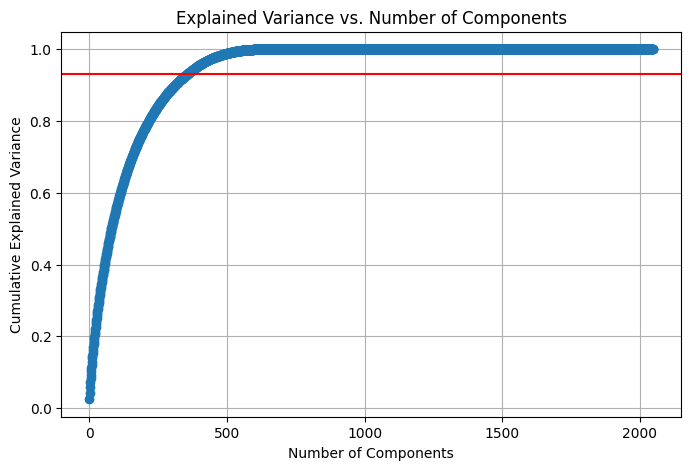

Optimal number of components to reach 93% explained variance: 355
355 [0.02467616 0.04290812 0.0590741  ... 1.         1.         1.        ]


In [54]:
# Dimensionality reduction with PCA and t-SNE
# PCA (Principal Component Analysis): Reduces high-dimensional fingerprint data to n dimensions 
#      (250 here, it is an orbitary number).
# t-SNE (t-distributed Stochastic Neighbor Embedding): Reduces the data further to 2D or 3D 
#      for better visualization purposes.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def find_optimal_pca_components(X, explained_variance_threshold=0.90):
    """
    Finds the optimal number of PCA components to reach the desired cumulative explained variance.

    Parameters:
    - X: np.ndarray, The input data matrix (n_samples, n_features).
    - explained_variance_threshold: float, The target cumulative explained variance ratio (default is 0.90).
    
    Returns:
    - optimal_components: int, Optimal number of components to reach the target explained variance.
    - cumulative_explained_variance: np.ndarray, Cumulative explained variance for each component.
    """
    # Standardize the data
    X = StandardScaler().fit_transform(X)

    # Fit PCA without specifying the number of components
    pca = PCA().fit(X)

    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine the optimal number of components
    optimal_components = np.argmax(cumulative_explained_variance >= explained_variance_threshold) + 1
    
    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='-')
    plt.grid()
    plt.show()
    
    print(f"Optimal number of components to reach {explained_variance_threshold*100:.0f}% explained variance: {optimal_components}")
    
    return optimal_components, cumulative_explained_variance

# Example usage with any n-dimensional data
# Replace `your_data` with your actual n-dimensional data matrix
# your_data = np.array(...)  # Replace this line with your data loading code
# For illustration, let's generate random data:
np.random.seed(42)
input_data = np.random.rand(100, 10)  # Example data with 100 samples and 10 features
input_data = fingerprints

# Correlation Coefficient 
#   65% is good or moderate
#   95% is strong relationship 
#   Anything between 70% to 90% is better
optimal_components, cumulative_explained_variance = find_optimal_pca_components(input_data, 
                                                                                explained_variance_threshold=0.93)

print (optimal_components, cumulative_explained_variance)

#Output 2
#Optimal number of components to reach 93% explained variance: 356

#Output 3
#Optimal number of components to reach 93% explained variance: 357

In [55]:
# Step B: Dimensionality reduction with PCA and t-SNE
# PCA (Principal Component Analysis): Reduces high-dimensional fingerprint data to n dimensions 
#      (250 here, it is an orbitary number).
# t-SNE (t-distributed Stochastic Neighbor Embedding): Reduces the data further to 2D or 3D 
#      for better visualization purposes.

#optimal_components = 250
pca = PCA(n_components=optimal_components)
fingerprints_reduced = pca.fit_transform(fingerprints)

# Further reduce dimensions with t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42)
fingerprints_2d = tsne.fit_transform(fingerprints_reduced)


In [56]:
print(fingerprints_reduced.shape, fingerprints_2d.shape)

#Output 2
#(2180, 390) (2180, 2)

#Output 3
#(2163, 357) (2163, 2)

(2164, 355) (2164, 2)


Optimal K value is:-  6


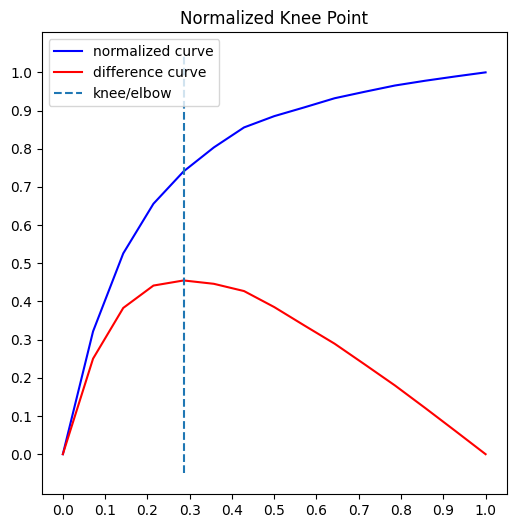

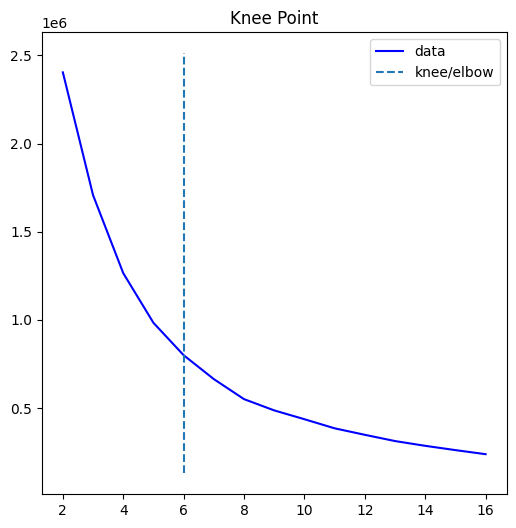

In [57]:
# Perform K-means++ clustering
# First step is to find optimal value for k (clusters)

# Method 1: Find optimal k value using silhouette score
from sklearn.metrics import silhouette_score
sil = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] #Optimal cluster is 
#range_n_clusters = range(2, 7, 1) #Optimal cluster is 
silhouette_avg = []
Sum_of_squared_distances = []

for num_clusters in range_n_clusters:
    # initialise kmeans option1
    #kmeans = KMeans(n_clusters=num_clusters
    #kmeans.fit(embeddings)
    #cluster_labels = kmeans.labels_
    
    # initialise kmeans option2
    #labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_Short).labels_
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++",random_state=42)
    cluster_labels = kmeans.fit(fingerprints_2d).labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(fingerprints_2d, cluster_labels))

    # inertia for elbow method. The Elbow method is used to find the elbow in the elbow plot. The elbow 
    # is found when the dataset becomes flat or linear after applying the cluster analysis algorithm
    Sum_of_squared_distances.append(kmeans.inertia_)

df_WSS_SIL = pd.DataFrame({'Clusters' : range_n_clusters, 'WSS' : Sum_of_squared_distances, 'sil' : silhouette_avg})

#sns.lineplot(x = 'Clusters', y = 'WSS', data = df_WSS_SIL, marker="+")
#plt.show()

#sns.lineplot(x = 'Clusters', y = 'sil', data = df_WSS_SIL, marker="+")
#plt.show()

kneedle = KneeLocator(range_n_clusters, Sum_of_squared_distances, 
                      curve="convex", direction="decreasing")
                      #curve="convex", direction="increasing")
                      #curve="concave", direction="increasing")
                      #curve="concave", direction="decreasing")

optimalK = kneedle.elbow
print("Optimal K value is:- ", optimalK)

kneedle.plot_knee_normalized() 
#Normalized : range_n_clusters, Sum_of_squared_distances are normalized to a sclae of 0 to 1
#Difference : Variation of Sum_of_squared_distances from range_n_clusters points

kneedle.plot_knee()

In [58]:
# Step C: Apply KMeans clustering
#kmeans = KMeans(n_clusters=optimalK, random_state=42)
#clusters = kmeans.fit_predict(fingerprints_2d)
#1. Clustering Method: KMeans++ is used here, but could use DBSCAN for density-based clustering, 
#     which is often effective for chemical data.
#2. Descriptors: Alternative descriptors can be used, like MACCS keys or RDKit descriptors, 
#     depending on further clustering needs.
#3. This approach segments the molecular structures by clustering them based on 
#     structural similarities, allowing to identify groups of chemically similar molecules.

kmeans = KMeans(n_clusters=optimalK, init='k-means++', 
                algorithm='auto', random_state=42)

#kmeans = KMeans(n_clusters=optimalK, init='k-means++', n_init='auto', # algorithm='lloyd',
#                random_state=42).fit(fingerprints_2d)
KMclusters = kmeans.fit_predict(fingerprints_2d)

#df['clusters'] = clusters

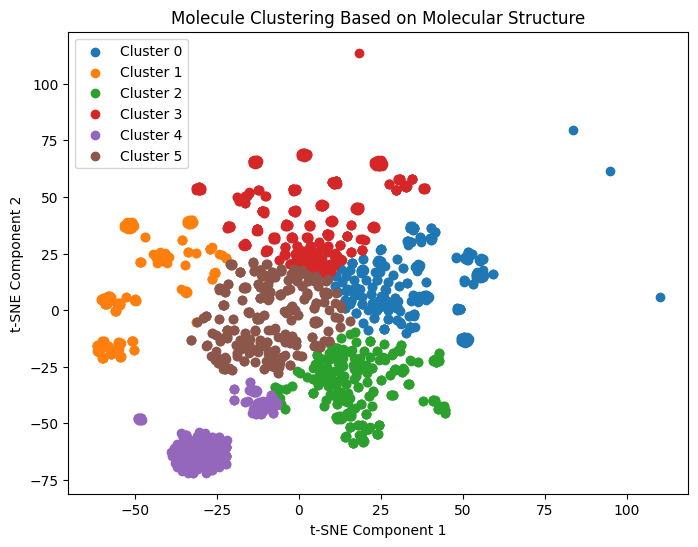

In [59]:
# Step D: Plot the clustered molecules in 2D space
#plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
for i, label in enumerate(set(KMclusters)):
    plt.scatter(fingerprints_2d[KMclusters == label, 0], fingerprints_2d[KMclusters == label, 1], 
                label=f'Cluster {label}')
plt.legend()
plt.title('Molecule Clustering Based on Molecular Structure')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [60]:
print (len(KMclusters), len(df))
df.head(2)

#Output 2
#2180 3261

#Output 3
#2163 3261

#Output 4
#2165 3261

2164 3261


,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles,chem2_names2,chem2_names2_status,chem2_names3,chem2_names3_fg_status
0,7444,D Site Insp,Descriptive Site Inspection : Pass/Fail 1/0,1.0,coded,AN-011262,STEANE PARK THE MANOR HOUSE STW,Descriptive Site Inspection : Pass/Fail 1/0,99,False,5,0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False,OTH-Descriptive Site Inspection : Pass/Fail 1/0,False
1,664,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.0,pres/nf,AN-011262,STEANE PARK THE MANOR HOUSE STW,"Visible oil or grease, significant trace: Pres...",99,False,5,0,"OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...","OTH-Visible oil or grease, significant trace: ...",False,"OTH-Visible oil or grease, significant trace: ...",False


In [61]:
df = df[df['chem2_names3_fg_status'] == True]
df['KMclusters'] = KMclusters
print(len(df))
df.head(2)

#2180

2164


,determinand_notation,determinand_name,determinand_definition,result,determinand_unit_name,samplingPoint_notation,samplingPoint_name,Chemical_Names,Chemical_Group,Metal,clusters8,clusters4,chem2_names,chem2_names_rev,chem2_smiles,chem2_names2,chem2_names2_status,chem2_names3,chem2_names3_fg_status,KMclusters
2,85,BOD ATU,BOD : 5 Day ATU,7.5,mg/l,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,BOD : 5 Day ATU,99,False,3,1,['BOD'],BOD,CC1=CC(=C(C=C1OC)C(CN)OC)OC,CC1=CC(=C(C=C1OC)C(CN)OC)OC,True,CC1=CC(=C(C=C1OC)C(CN)OC)OC,True,5
3,111,Ammonia(N),Ammoniacal Nitrogen as N,10.4,mg/l,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,Nitrogen,15,False,2,10,['Nitrogen'],Nitrogen,N#N,N#N,True,N#N,True,1


In [62]:
# Save the Extracted Chemical Names
savedata(df, "06_nb_final_chem2_clusters.csv")

('saved, Location: ',
 'gcs://rdmai_dev_data/cleansed/06_nb_final_chem2_clusters.csv')

In [63]:
#Step 4: 
    # Now we have obtained the extracted chemical names and its molecular formula. 
    # We shall now cluster the chemicals using the molecular formula obtained in previous step based on its molecular structure

In [64]:
#Clustering using DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler


In [65]:
# Standardize features (important for DBSCAN)
#X = StandardScaler().fit_transform(X) #This is commented since the data is already standardized using tSNA & PCA 

# Create DBSCAN model
# eps: maximum distance between two samples for them to be considered as neighbors
# min_samples: minimum number of points to form a dense region
dbscan = DBSCAN(eps=7.3, min_samples=10)
DBSCANclusters = dbscan.fit_predict(fingerprints_2d)
print(max(DBSCANclusters))

#21
#20
#19

20


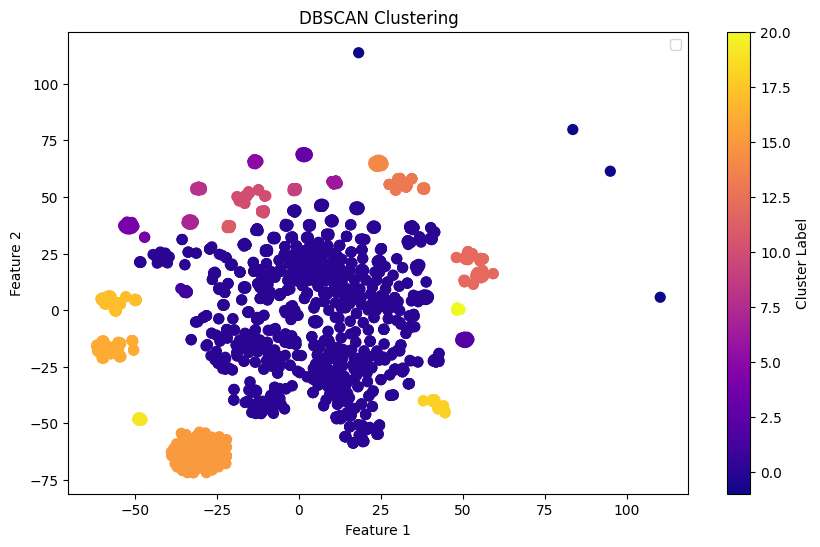

In [66]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(fingerprints_2d[:, 0], fingerprints_2d[:, 1], c=DBSCANclusters, cmap='plasma', s=50)
plt.title("DBSCAN Clustering")
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [67]:
#dbutils.notebook.exit("End Workload - Scrip stopped")

In [68]:
#End CARD
#In line comments completed 11-May-2025